# Prediction of exchange current density from atomic data

📚 This notebook explores prediction of exchange current densities from common atomic physical properties and reaction thermodynamic descriptors (i.e. free energy or thermodynamic voltage).

⚡ Exchange current densities are effectively an electrochemical reaction's "rate constant" - which is highly sensitive to its environment. The same reaction occurring on the surface of a slightly different metal, or in the same pH solution but with a dilute dopant in the electrolyte, can have completely different exchange current densities - it can vary over 30 orders of magnitude.

✅ It's safe to say then - with such general descriptors only attached to the reacting atom - we can only predict within a couple orders of magnitude. We're looking for reasonable atomic trends that might align with known phenomena (such as Marcus electron transfer theory, which says every electron transfer is generally rate limited by a thermal transition state of the atom - keep this in mind!)

Our workplan:
1. Import exchange current density data and apply invertible transformations - ones that make it easier for the model to fit to but can recover the true dimensional value.
2. Explore the dataset using a correlation matrix to understand which variables might be most valuable to explore. With small datasets, minimizing independent variables is paramount in creating robust models.
3. Pick a handful of strong variables, and train multiple models while keeping a small portion of the data hidden from the model to test the model against.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy

# Import
data = pd.read_csv('/content/FinalExchangeCurr2.csv')

# Apply invertible transformation (log) to predicted variable
reactingElements = data.drop('reacting element', axis=1, inplace = True)
print(numpy.mean(data['Log10 ECD']))
print(numpy.std(data['Log10 ECD']))

# Create a "scaler" object for each variable - transform each dataset to vary only between 0-1. This does not impact the variance of the model but makes it easier to numerically fit to
s = StandardScaler()
ds = s.fit_transform(data[['Std Reduction Pot','concentration (M)' ,'Ionization energy (eV)', 'Atomic radius', 'Atomic mass', 'Atomic volume cm3/mol)', 'Dipole polarizability (au)', 'Electron affinity (eV)', 'Allen Electronegativity (eV)', 'Ghosh Electronegativity', 'Pauling Electronegativity', 'Ionic radius (pm)', 'Cohesive Energy (eV/atom)']])

ds = pd.DataFrame(ds,columns=data[['Std Reduction Pot','concentration (M)' ,'Ionization energy (eV)', 'Atomic radius', 'Atomic mass', 'Atomic volume cm3/mol)', 'Dipole polarizability (au)', 'Electron affinity (eV)', 'Allen Electronegativity (eV)', 'Ghosh Electronegativity', 'Pauling Electronegativity', 'Ionic radius (pm)', 'Cohesive Energy (eV/atom)']].columns)
ds = pd.concat([ds,reactingElements, data[['Exchange Current Density', 'Log10 ECD']]], axis=1)

# Clean up null values
ds = ds.dropna()
ds


-4.359386936695534
4.740394116329076


,Std Reduction Pot,concentration (M),Ionization energy (eV),Atomic radius,Atomic mass,Atomic volume cm3/mol),Dipole polarizability (au),Electron affinity (eV),Allen Electronegativity (eV),Ghosh Electronegativity,Pauling Electronegativity,Ionic radius (pm),Cohesive Energy (eV/atom),Exchange Current Density,Log10 ECD
0,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-9.28
1,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-8.86
2,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-8.82
3,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-8.60
4,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-8.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-6.25
3371,-0.20,0.14,2.09,-2.22,-1.26,0.58,-1.28,0.05,1.54,1.98,1.26,-1.03,-1.55,0.00,-7.05
3372,0.98,0.14,-0.86,0.21,-0.42,-0.50,0.91,-0.45,-1.03,-0.94,-0.85,0.41,1.32,0.00,-13.10
3373,0.98,0.14,-0.86,0.21,-0.42,-0.50,0.91,-0.45,-1.03,-0.94,-0.85,0.41,1.32,0.00,-13.10


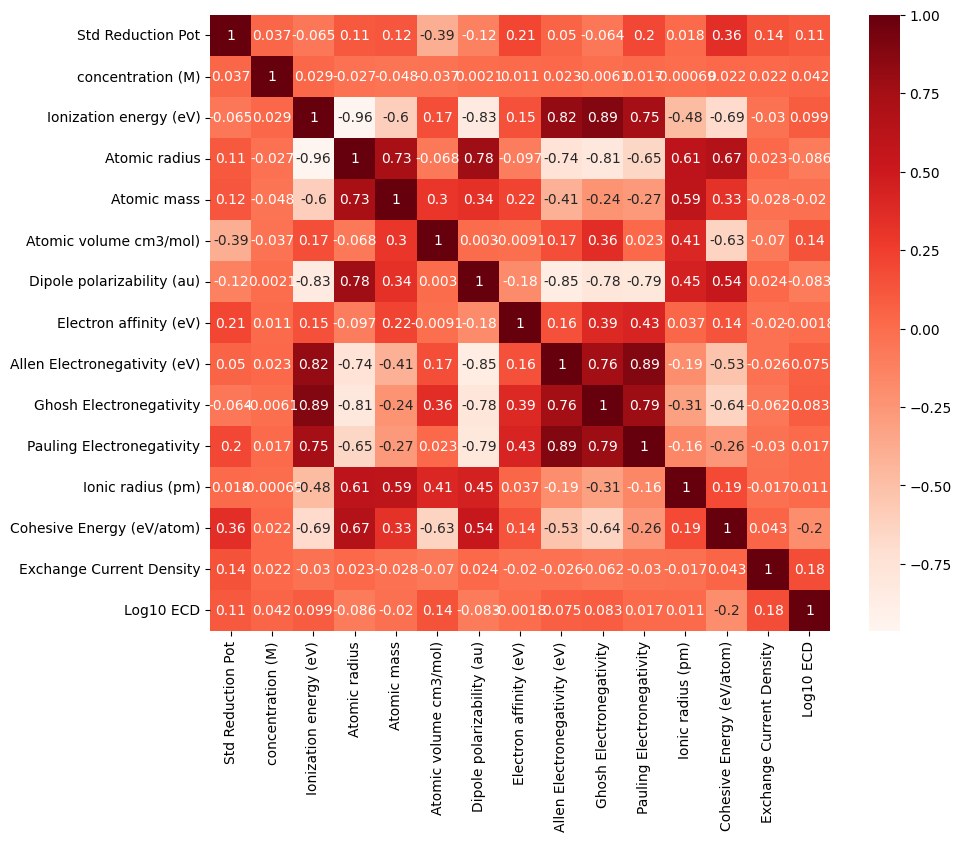

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Display all variables as correlation matrices - reporting r^2 of each variable when linearly correlated. A general measurement of "relatedness"
plt.figure(figsize=(10,8))
cor = ds.corr()
sns.heatmap(cor, annot=True,cmap=plt.cm.Reds)
plt.show()

Although the r^2 values are low - we can use them as a relative point of comparison to evaluate strength of fit.

The correlation matrix shows that atomic volume, cohesive energy, and ionization energy seem to correlate - which actually aligns with our understanding of electrochemical kinetics - that "how stuck atoms are together" (cohesive energy), "how easily electrons are pulled" (atomic volume - easier to pull from bigger atoms), and "how easily can we induce a charge" (ionization energy) all have notable impacts on electrochemical kinetics.

Using these three variables, we can then try training a couple models:

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(ds, test_size=0.2, shuffle=True, random_state=1)
#3,1,4

In [ ]:
train_dropna = train.dropna()
test_dropna = test.dropna()

train_dropna = train_dropna.astype({"Exchange Current Density":"float","Log10 ECD":"float",
                                    # 'concentration (M)':"float" ,
                                    # 'electrons transferred':"float",
                                    # 'Std Reduction Pot':"float",
                                    'Ionization energy (eV)':"float",
                                    'Atomic radius':"float",
                                    'Atomic mass':"float",
                                    'Atomic volume cm3/mol)':"float",
                                    'Dipole polarizability (au)':"float",
                                    'Electron affinity (eV)':"float",
                                    'Allen Electronegativity (eV)':"float",
                                    'Ghosh Electronegativity':"float",
                                    'Pauling Electronegativity':"float",
                                    'Ionic radius (pm)':"float",
                                    'Cohesive Energy (eV/atom)': 'float'})

train_dropna = train_dropna.astype({"Exchange Current Density":"float","Log10 ECD":"float",
                                    # 'concentration (M)':"float" ,
                                    # 'electrons transferred':"float",
                                    # 'Std Reduction Pot':"float",
                                    'Ionization energy (eV)':"float",
                                    'Atomic radius':"float",
                                    'Atomic mass':"float",
                                    'Atomic volume cm3/mol)':"float",
                                    'Dipole polarizability (au)':"float",
                                    'Electron affinity (eV)':"float",
                                    'Allen Electronegativity (eV)':"float",
                                    'Ghosh Electronegativity':"float",
                                    'Pauling Electronegativity':"float",
                                    'Ionic radius (pm)':"float",
                                    'Cohesive Energy (eV/atom)': 'float'})

allX = ds[[ 'Atomic radius', 'Ionization energy (eV)', 'Cohesive Energy (eV/atom)']]
allY = -ds['Log10 ECD']

trainX = train_dropna[[ 'Atomic volume cm3/mol)', 'Ionization energy (eV)', 'Cohesive Energy (eV/atom)']]

trainY = -train_dropna['Log10 ECD']

testX = test_dropna[[ 'Atomic volume cm3/mol)', 'Ionization energy (eV)', 'Cohesive Energy (eV/atom)']]


testY = -test_dropna['Log10 ECD']

trainY

3365    4.88
2457    7.00
535     5.80
350     7.30
2953    6.29
        ... 
1770   13.00
2437    4.10
2735   -0.41
555    12.77
2673   -1.60
Name: Log10 ECD, Length: 1154, dtype: float64

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

models, predictions = reg.fit(trainX, testX, trainY, testY)



In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
BaggingRegressor,0.12,0.15,4.11,0.02
RandomForestRegressor,0.12,0.14,4.12,0.11
XGBRegressor,0.12,0.14,4.13,0.03
DecisionTreeRegressor,0.12,0.14,4.13,0.01
ExtraTreesRegressor,0.12,0.14,4.13,0.08
ExtraTreeRegressor,0.12,0.14,4.13,0.01
GaussianProcessRegressor,0.12,0.14,4.13,0.02
GradientBoostingRegressor,0.11,0.14,4.13,0.12
LGBMRegressor,0.11,0.13,4.14,0.02


In [ ]:
# models
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

regr = RandomForestRegressor(max_depth = None, min_samples_split= 10, n_estimators = 200, random_state=0)

cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(regr, trainX, trainY, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('RMSE: %.3f (%.3f)' % (numpy.mean(n_scores), numpy.std(n_scores)))

regr.fit(trainX, trainY)


print(len(trainX))

plt.plot(testY, (regr.predict(testX)), 'o')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# plt.title('Plot of Y against X')
plt.show()


saved = list(numpy.array(test_dropna[[ 'Ionization energy (eV)', 'Atomic radius', 'Atomic mass', 'Atomic volume cm3/mol)', 'Dipole polarizability (au)', 'Electron affinity (eV)', 'Allen Electronegativity (eV)', 'Ghosh Electronegativity', 'Pauling Electronegativity', 'Ionic radius (pm)', 'Cohesive Energy (eV/atom)']].to_numpy(),dtype='float'))
print((len(saved[0])))
# saved[0].append(list(numpy.array(testY.to_numpy(),dtype='float')))
# numpy.append(saved[0],list(numpy.array(testY.to_numpy(),dtype='float')))
# saved[0].append(list(numpy.array(regr.predict(testX),dtype='float')))
# numpy.append(saved[0],list(numpy.array(regr.predict(testX),dtype='float')))

print(type(testY))
# testY = s.inverse_transform(testX)

da = []
for i in range(len(saved)):
  # print(testY.to_numpy()[i])
  print(numpy.append(saved[i],[testY.to_numpy()[i],(regr.predict(testX)[i])]))
  da.append(numpy.append(saved[i],[testY.to_numpy()[i],(regr.predict(testX)[i])]))


print((saved))
numpy.savetxt("foo.csv", da, delimiter=",")

#average horizontal bars and recorrelate parity i suppose


So - using those three variables only, we've been able to predict a variable that ranges over 30 orders of magnitudes - and predict it within ~3-4 orders of magnitude. Although the performance isn't "amazing" - using data only, we've confirmed trends that corroborate physical knowledge, while only using generically accessible information on the reactions.

You'll notice that there are horizontal lines that span across the parity plot - this is a symptom of the fact that we're using atomic descriptors only - those horizontal lines represent reactions for a given element. Since we're only using atomic descriptors, all of those reactions will have the same predicted value.

Now we can save our model for later use and/or validation:

In [ ]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the random forest regressor
regr = RandomForestRegressor(max_depth=None, min_samples_split=10, n_estimators=200, random_state=0)

# Define the preprocessing pipeline
pipeline = Pipeline([
    ('scaler', s),
    ('model', regr)
])

# Perform cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(pipeline, trainX, trainY, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# Report performance
print('RMSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the pipeline on the entire training data
pipeline.fit(trainX, trainY)

# Save the full pipeline (including scaler and model) to a file using pickle
with open('pipeline_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Load the saved pipeline from the file
with open('pipeline_model.pkl', 'rb') as file:
    saved_pipeline = pickle.load(file)

# Use the loaded pipeline for prediction on new data
new_data = scaler.transform(new_data)  # Assuming new_data is the input data you want to predict
predictions = saved_pipeline.predict(new_data)